In [1]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from collections import defaultdict

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, skip=True):
        super(Bottleneck, self).__init__()
        self.skip = skip
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = None
        if stride != 1 or in_planes != self.expansion * planes:
            self.downsample = nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out = out + identity
        return self.relu(out)

class CustomResNet50(nn.Module):
    def __init__(self, skip=True):
        super(CustomResNet50, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3, skip)
        self.layer2 = self._make_layer(128, 4, skip, stride=2)
        self.layer3 = self._make_layer(256, 6, skip, stride=2)
        self.layer4 = self._make_layer(512, 3, skip, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, 10)

    def _make_layer(self, planes, blocks, skip, stride=1):
        layers = [Bottleneck(self.in_planes, planes, stride, skip)]
        self.in_planes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_planes, planes, skip=skip))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

model = CustomResNet50(skip=True).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

selected_layers = ["conv1", "layer1.0.conv1", "layer2.0.conv2", "layer3.5.conv3", "fc"]
gradients = {}

def register_hooks(model):
    for name, module in model.named_modules():
        if name in selected_layers and (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            gradients[name] = []
            def hook(module, grad_input, grad_output, name=name):
                gradients[name].append(grad_output[0].norm().item())
            module.register_full_backward_hook(hook)

register_hooks(model)

In [2]:
epoch_gradients = defaultdict(list)

In [5]:
def train(model, epochs=1):
    model.train()
    for epoch in tqdm(range(epochs)):
        # Temporary storage for one epoch
        batch_grads = defaultdict(list)

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # After backward, batch-level gradients are in global `gradients`
            for layer in selected_layers:
                if gradients[layer]:
                    batch_grads[layer].extend(gradients[layer])
                    gradients[layer].clear()  # Clear for next batch

        # Sample 20 values (or pad with zeros if less) for this epoch
        for layer in selected_layers:
            layer_grads = batch_grads[layer]
            if len(layer_grads) >= 20:
                sampled = np.random.choice(layer_grads, 20, replace=False)
            else:
                sampled = np.pad(layer_grads, (0, 20 - len(layer_grads)), constant_values=0)
            epoch_gradients[layer].append(sampled.tolist())

        print(f"Epoch {epoch+1} complete")


In [ ]:
train(model, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation

In [5]:
# Step 2: Function to create and save KDE animation
def create_kde_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='kde_gradients.gif'):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(epoch):
        ax.clear()
        x_grid = np.linspace(0, 2, 200)
        for layer in layers:
            data = epoch_gradients[layer][epoch]
            if len(data) > 1 and np.isfinite(data).all():
                kde = gaussian_kde(data, bw_method=0.3)
                ax.plot(x_grid, kde(x_grid), label=layer)
        ax.set_xlim(0, 2)
        ax.set_ylim(0, 5)
        ax.set_title(f"Gradient Distributions - Epoch {epoch + 1}")
        ax.set_xlabel("Gradient Norm")
        ax.set_ylabel("Density")
        ax.legend()

    ani = FuncAnimation(fig, update, frames=num_epochs, repeat=False)
    ani.save(save_path, writer='pillow', fps=1)
    print(f"Saved animation to {save_path}")

In [6]:

layers = ['conv1', 'conv_mid', 'conv_deep', 'fc1']

In [11]:
len(epoch_gradients["conv1"])

31250

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x70ed0b714d60> (for post_execute), with arguments args (),kwargs {}:


TypeError: object of type 'float' has no len()

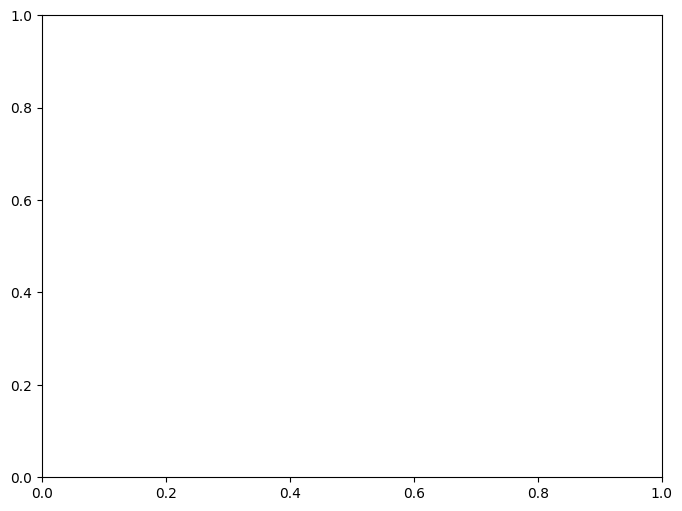

In [ ]:
# Step 3: Run it
create_kde_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='kde_gradients.gif')

In [10]:
import json

with open("outputs/gradients_resnet50_with_skip.json", "w") as f:
    json.dump(gradients, f)